In [7]:
import os
import time
from math import sqrt

from dotenv import load_dotenv
import psycopg2
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import joblib
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeClassifier
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, explained_variance_score,
    r2_score, confusion_matrix, accuracy_score
)

In [8]:
def get_stock_price_data_from_db(ticker):
    """
    Download the stock price data from the TimescaleDB database
    and return it in a Pandas DataFrame.
    """
    sql = f"""
        select
            time,
            ticker,
            round(close_adj, 2) as price,
            round(high, 2) as high,
            round(low, 2) as low,
            volume
        from public.stock_prices
        where ticker = '{ticker}'
        order by
            ticker,
            time;
    """
    # Load the database environment variables from the current directory
    load_dotenv()
    
    with psycopg2.connect(
        host=os.getenv('POSTGRES_HOST'),
        port=os.getenv("POSTGRES_PORT"), 
        dbname=os.getenv("POSTGRES_DATABASE"), 
        user=os.getenv("POSTGRES_USER"), 
        password=os.getenv("POSTGRES_PASSWORD"), 
        connect_timeout=5
    ) as conn:
        with conn.cursor() as cursor:
            cursor.execute(sql)
            columns = [str.lower(x[0]) for x in cursor.description]
            rows = cursor.fetchall()

    # Return a DataFrame with the results
    return pd.DataFrame(rows, columns=columns)

In [9]:
# Get stock price data from the TimescaleDB
df = get_stock_price_data_from_db(ticker='TSLA')

# Look at the first 3 rows
df.head(3)

time ticker price  high   low   volume
0 2011-01-31   TSLA  4.82  4.82  4.70  4151500
1 2011-02-01   TSLA  4.78  4.95  4.71  3539000
2 2011-02-02   TSLA  4.79  4.84  4.73  2847500

In [10]:
# Look at the column types.
# We'll need to convert everything to floating point first, to avoid errors
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    2517 non-null   datetime64[ns]
 1   ticker  2517 non-null   object        
 2   price   2517 non-null   object        
 3   high    2517 non-null   object        
 4   low     2517 non-null   object        
 5   volume  2517 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 118.1+ KB


In [11]:
# Convert the numeric columns to numeric 'float64'
df["price"] = pd.to_numeric(df["price"])
df["high"] = pd.to_numeric(df["high"])
df["low"] = pd.to_numeric(df["low"])
df["volume"] = pd.to_numeric(df["volume"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    2517 non-null   datetime64[ns]
 1   ticker  2517 non-null   object        
 2   price   2517 non-null   float64       
 3   high    2517 non-null   float64       
 4   low     2517 non-null   float64       
 5   volume  2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 118.1+ KB


<AxesSubplot:>

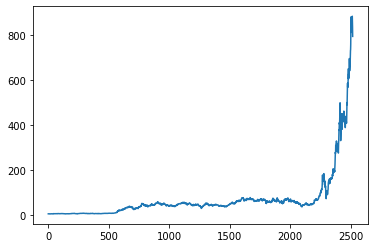

In [12]:
# Plot the data to see what we're dealing with
df['price'].plot()

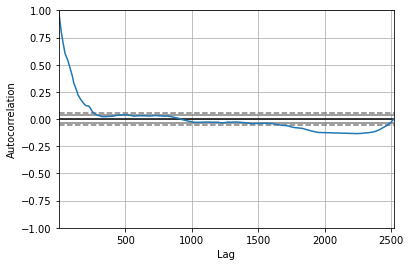

In [13]:
# Plot the autocorrelation for a large number of lags in the time series
# If the autocorrelation value is large, then the price depends on previous prices,
# which is almost always the case with stock prices
autocorrelation_plot(df['price'])
plt.show()

# Feature Engineering

In [14]:
# Create a new column with the price from the previous time period, 
# and back-fill the value so we don't have any null values
df["price_prev"] = df["price"].shift(1).bfill()
# Calculate the day-over-day price change
df['delta'] = df['price'] - df['price_prev']
# Get tomorrow's price delta, which is how we'll calculate our profits
df['delta_tm'] = df['delta'].shift(-1)
# Calculate the percentage change in price, or the return
df['rt'] = df['delta'] / df['price_prev']
# Get the lagged returns for more previous days, since there's autocorrelation
df['rt1'] = df['rt'].shift(1)
df['rt2'] = df['rt'].shift(2)
df['rt3'] = df['rt'].shift(3)
df['rt4'] = df['rt'].shift(4)
df['rt5'] = df['rt'].shift(5)
# Get the next day's return, which is ultimately what we're trying to forecast/predict
df['rt_tm'] = df['rt'].shift(-1)
# Make a simpler up/down indicator, for whether the return is positive or negative
df['up_down_tm'] = np.where(df['rt_tm'] > 0, 1, 0)
# Make an up-down indicator for the returns over the next week
df['price_1wk'] = df['price'].shift(-7)
df['up_down_1wk'] = np.where(df['price_1wk'] > df['price'], 1, 0)
df.head(5)

time ticker  price  high   low     volume  price_prev  delta  \
0 2011-01-31   TSLA   4.82  4.82  4.70  4151500.0        4.82   0.00   
1 2011-02-01   TSLA   4.78  4.95  4.71  3539000.0        4.82  -0.04   
2 2011-02-02   TSLA   4.79  4.84  4.73  2847500.0        4.78   0.01   
3 2011-02-03   TSLA   4.73  4.78  4.63  2560000.0        4.79  -0.06   
4 2011-02-04   TSLA   4.69  4.73  4.64  2720000.0        4.73  -0.04   

   delta_tm        rt       rt1       rt2       rt3  rt4  rt5     rt_tm  \
0     -0.04  0.000000       NaN       NaN       NaN  NaN  NaN -0.008299   
1      0.01 -0.008299  0.000000       NaN       NaN  NaN  NaN  0.002092   
2     -0.06  0.002092 -0.008299  0.000000       NaN  NaN  NaN -0.012526   
3     -0.04 -0.012526  0.002092 -0.008299  0.000000  NaN  NaN -0.008457   
4     -0.08 -0.008457 -0.012526  0.002092 -0.008299  0.0  NaN -0.017058   

   up_down_tm  price_1wk  up_down_1wk  
0           0       4.64            0  
1           1       4.64            0  
2           0       4.65            0  
3           0       4.62            0  
4           0       4.57            0

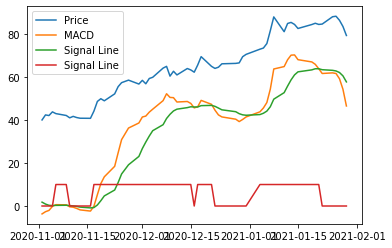

In [16]:
# Calculate the 7-day and 14-day rolling average returns, and the delta between them
df['price_7d'] = df['price'].rolling(window=7, min_periods=1).mean()
df['price_14d'] = df['price'].rolling(window=14, min_periods=1).mean()
# Moving average convergence-divergence (MACD) technical indicator
macd_12 = df['price'].ewm(span=12, adjust=False).mean()
macd_26 = df['price'].ewm(span=26, adjust=False).mean()
df['macd'] = macd_12 - macd_26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
# df['macd_delta'] = df['macd_signal'] - df['macd']
df['macd_binary'] = np.where(df['macd'] > df['macd_signal'], 10, 0)
df['price_7d_14d'] = df['price_7d'] / df['price_14d']
df['price_7d_14d_delta'] = df['price_7d_14d'] - df['price_7d_14d'].shift(1)

df2 = df[df['time'] >= '2020-11-01']
plt.plot(df2['time'], df2['price']/10, label='Price')
plt.plot(df2['time'], df2['macd'], label='MACD')
plt.plot(df2['time'], df2['macd_signal'], label='Signal Line')
plt.plot(df2['time'], df2['macd_binary'], label='Signal Line')
plt.legend(loc='upper left')
plt.show()


<AxesSubplot:>

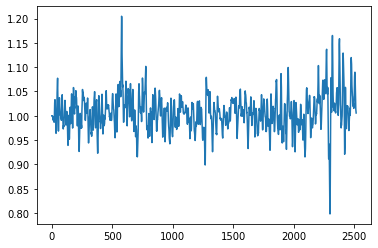

In [17]:
df['price_7d_14d'].plot()

In [18]:
# Calculate the 14-day relative strength index (RSI) technical indicator
# Window length for RSI moving average
window_length = 14
# Calculate the days where the price went up, otherwise zero
up = pd.Series(np.where(df['delta'] > 0, df['delta'], 0))
# Calculate the days where the price went down, otherwise zero
down = pd.Series(np.where(df['delta'] < 0, df['delta'], 0))
roll_up = up.rolling(window=window_length, min_periods=1).mean()
roll_down = down.abs().rolling(window=window_length, min_periods=1).mean()
df['RSI'] = 100.0 - (100.0 / (1.0 + (roll_up / roll_down)))
df.tail(3)


time ticker   price    high     low      volume  price_prev  delta  \
2514 2021-01-27   TSLA  864.16  891.50  858.66  27334000.0      883.09 -18.93   
2515 2021-01-28   TSLA  835.43  848.00  801.00  26378000.0      864.16 -28.73   
2516 2021-01-29   TSLA  793.53  842.41  780.10  34758800.0      835.43 -41.90   

      delta_tm        rt  ...  price_1wk  up_down_1wk    price_7d   price_14d  \
2514    -28.73 -0.021436  ...        NaN            0  859.240000  849.781429   
2515    -41.90 -0.033246  ...        NaN            0  857.937143  851.166429   
2516       NaN -0.050154  ...        NaN            0  849.805714  844.988571   

           macd  macd_signal  macd_binary  price_7d_14d  price_7d_14d_delta  \
2514  59.219512    62.117723            0      1.011131           -0.002832   
2515  54.337933    60.561765            0      1.007955           -0.003176   
2516  46.551648    57.759742            0      1.005701           -0.002254   

            RSI  
2514  65.404990  
2515  53.031677  
2516  35.474119  

[3 rows x 27 columns]

<AxesSubplot:>

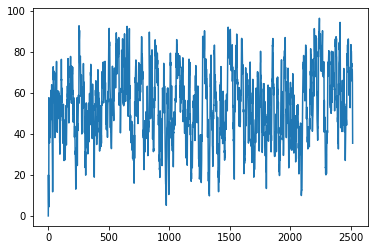

In [19]:
# Take a look at the RSI technical indicator
df['RSI'].plot()

In [20]:
# Calculate the 3-day commodity channel index (CCI) technical indicator
df['CCI'] = (df['price'] - df['price'].rolling(3, min_periods=1).mean()) \
    / (0.015 * df['price'].rolling(3, min_periods=1).std())
# df['CCI'].plot()

In [21]:
# Calculate the ease of movement (EVM) volume-based technical oscillator
distance_moved = ((df['high'] + df['low'])/2 -
    (df['high'].shift(1).bfill() + df['low'].shift(1).bfill())/2)
box_ratio = (df['volume'] / 100_000_000) / (df['high'] - df['low'])
df['EMV'] = distance_moved / box_ratio
# df['EMV'].plot()

In [22]:
# Calculate the "force index" technical oscillator,
# a measure of the "forcefullness" of the price change
df['FI'] = df['delta'] * df['volume']
# df['FI'].plot()

In [23]:
# Replace any infinite values with nulls (np.nan), and then drop all null/NA values
print(f"df.shape before: {df.shape}")
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print(f"df.shape after: {df.shape}")
df.tail(3)

df.shape before: (2517, 30)
df.shape after: (2505, 30)


time ticker   price   high     low      volume  price_prev  delta  \
2507 2021-01-15   TSLA  826.16  859.9  819.10  38647900.0      845.00 -18.84   
2508 2021-01-19   TSLA  844.55  850.0  833.00  25367000.0      826.16  18.39   
2509 2021-01-20   TSLA  850.45  859.5  837.28  25665900.0      844.55   5.90   

      delta_tm        rt  ...   price_14d       macd  macd_signal  \
2507     18.39 -0.022296  ...  773.803571  68.093953    62.432293   
2508      5.90  0.022260  ...  786.722143  67.048218    63.355478   
2509     -5.46  0.006986  ...  799.897857  65.935482    63.871479   

      macd_binary  price_7d_14d  price_7d_14d_delta        RSI        CCI  \
2507           10      1.085964           -0.003577  72.924278 -72.745915   
2508           10      1.073309           -0.012655  74.113381  37.086202   
2509           10      1.050348           -0.022960  74.359516  52.955574   

              EMV            FI  
2507 -1200.841443 -7.281264e+08  
2508   134.032404  4.664991e+08  
2509   596.494960  1.514288e+08  

[3 rows x 30 columns]

In [24]:
n_training_records = int(0.6*len(df))
df_train = df.iloc[:n_training_records]
df_test = df.iloc[n_training_records:]
print(f"df_train.shape: {df_train.shape}")
print(f"df_test.shape: {df_test.shape}")

df_train.shape: (1503, 30)
df_test.shape: (1002, 30)


In [25]:
df.columns

Index(['time', 'ticker', 'price', 'high', 'low', 'volume', 'price_prev',
       'delta', 'delta_tm', 'rt', 'rt1', 'rt2', 'rt3', 'rt4', 'rt5', 'rt_tm',
       'up_down_tm', 'price_1wk', 'up_down_1wk', 'price_7d', 'price_14d',
       'macd', 'macd_signal', 'macd_binary', 'price_7d_14d',
       'price_7d_14d_delta', 'RSI', 'CCI', 'EMV', 'FI'],
      dtype='object')

In [26]:
# Isolate the "features" or "explanatory variables" from
# the value we're trying to predict (future price movements)
features_wanted = ['rt', 'rt1', 'rt2', 'rt3', 'rt4', 'rt5', 'price_7d_14d', 'price_7d_14d_delta', 'macd_binary', 'RSI', 'CCI', 'EMV', 'FI']
X = df[features_wanted].values
X_train = df_train[features_wanted].values
X_test = df_test[features_wanted].values

y_feature = 'up_down_1wk'
y = df[y_feature].values
y_train = df_train[y_feature].values
y_test = df_test[y_feature].values

print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")


X.shape: (2505, 13)
y.shape: (2505,)
X_train.shape: (1503, 13)
y_train.shape: (1503,)
X_test.shape: (1002, 13)
y_test.shape: (1002,)


In [27]:
# Calculate the z-score with mean of 0 and standard deviation of 1
# In other words, standardize the data
ss = StandardScaler()
X_scaled = ss.fit_transform(df[features_wanted])
# Add a 1 for the intercept
X_scaled = sm.add_constant(X_scaled)

# model_ols = sm.OLS(y, X_scaled)
# results_ols = model_ols.fit()
# print(results_ols.summary())

model_logit = sm.Logit(y, X_scaled)
results_logit = model_logit.fit()
print(results_logit.summary())


Optimization terminated successfully.
         Current function value: 0.681037
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2505
Model:                          Logit   Df Residuals:                     2491
Method:                           MLE   Df Model:                           13
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:                0.003144
Time:                        21:12:09   Log-Likelihood:                -1706.0
converged:                       True   LL-Null:                       -1711.4
Covariance Type:            nonrobust   LLR p-value:                    0.6309
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2849      0.040      7.041      0.000       0.206       0.364
x1             0.0554      0.

# Data Preparation for Machine Learning

In [28]:
# Scale the data between 0 and 1
# mms = MinMaxScaler(feature_range=(0,1))

# Calculate the z-score with mean of 0 and standard deviation of 1
# In other words, standardize the data
ss = StandardScaler()

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=2)


In [87]:
# # Regression machine learning models to test
# ml_pipe_ols = Pipeline([('scale', ss), ('ols', LinearRegression())])
# ml_pipe_ridge = Pipeline([('scale', ss), ('ridge', Ridge())])
# ml_pipe_dtab = Pipeline([('scale', ss), ('dtab', AdaBoostRegressor())])
# ml_pipe_rf = Pipeline([('scale', ss), ('rf', RandomForestRegressor())])
# ml_pipe_sv = Pipeline([('scale', ss), ('sv', SVR())])
# ml_pipe_knn = Pipeline([('scale', ss), ('knn', KNeighborsRegressor())])
# ml_pipe_mlp = Pipeline([('scale', ss), ('mlp', MLPRegressor())])

In [29]:
# Classification machine learning models to test
ml_pipe_ols = Pipeline([('scale', ss), ('ols', LogisticRegression())])
ml_pipe_ridge = Pipeline([('scale', ss), ('ridge', RidgeClassifier())])
ml_pipe_dtab = Pipeline([('scale', ss), ('dtab', AdaBoostClassifier())])
ml_pipe_rf = Pipeline([('scale', ss), ('rf', RandomForestClassifier())])
ml_pipe_sv = Pipeline([('scale', ss), ('sv', SVC())])
ml_pipe_knn = Pipeline([('scale', ss), ('knn', KNeighborsClassifier())])
ml_pipe_mlp = Pipeline([('scale', ss), ('mlp', MLPClassifier())])

In [89]:
# # Regression hyper-parameter tuning grids
# param_grid_ols = [{'ols__fit_intercept': [True, False]}]
# param_grid_ridge = [{'ridge__alpha': [0, 0.001, 0.1, 1.0, 5, 10, 50, 100, 1000, 10000, 100000]}]
# param_grid_dtab = [{
#     'dtab__n_estimators': [50, 100],
#     'dtab__learning_rate': [0.75, 1.0, 1.5],
#     'dtab__loss' : ['linear', 'square', 'exponential'],
# }]
# param_grid_rf = [{
#     'rf__n_estimators': [100, 200],
#     'rf__max_features': ['auto', 'sqrt', 'log2'],
#     'rf__max_depth' : [2,4,8],
#     'rf__criterion' :['mse']
# }]
# param_grid_mlp = [{
#     'mlp__activation': ['relu', 'tanh'],
#     'mlp__solver': ['adam', 'sgd'],
#     'mlp__alpha': [0.01, 0.1, 1, 10, 100]
# }]
# param_grid_sv = [{
#     'sv__kernel': ['rbf', 'linear', 'poly'],
#     'sv__C': [0.001, 0.01, 0.1, 1, 10],
#     'sv__gamma': [0.001, 0.01, 0.1, 1],
#     'sv__epsilon': [0.1,0.2,0.3,0.5],
# }]
# param_grid_knn = [{
#     'knn__n_neighbors': [8, 10, 12, 14, 16, 18],
#     'knn__weights': ['uniform', 'distance'],
#     'knn__p': [1, 2],
#     'knn__n_jobs': [1, -1],
# }]

In [30]:
# Classification hyper-parameter tuning grids
param_grid_ols = [{'ols__fit_intercept': [True, False]}]
param_grid_ridge = [{'ridge__alpha': [0, 0.001, 0.1, 1.0, 5, 10, 50, 100, 1000, 10000, 100000]}]
param_grid_dtab = [{
    'dtab__n_estimators': [50, 100],
    'dtab__learning_rate': [0.75, 1.0, 1.5],
}]
param_grid_rf = [{
    'rf__n_estimators': [100, 200],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth' : [2,4,8],
}]
param_grid_mlp = [{
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.01, 0.1, 1, 10, 100]
}]
param_grid_sv = [{
    'sv__kernel': ['rbf', 'linear', 'poly'],
    'sv__C': [0.01, 0.1, 1, 10],
    'sv__gamma': [0.01, 0.1, 1],
}]
param_grid_knn = [{
    'knn__n_neighbors': [8, 10, 12, 14, 16, 18],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],
    'knn__n_jobs': [1, -1],
}]

In [31]:
def grid_search_cross_validate(X, y, name,
    estimator,
    param_grid,
    scoring='accuracy',
    cv=4,
    return_train_score=True
):
    """Perform grid-search hyper-parameter tuning and
    train/test cross-validation to prevent overfitting"""

    time_start = time.time()
    gs = GridSearchCV(estimator=estimator, param_grid=param_grid,
        scoring=scoring, cv=cv, return_train_score=return_train_score)
    gs.fit(X, y)
    seconds_elapsed = time.time() - time_start

    print(f"{name} took {round(seconds_elapsed)} seconds")
    print(f"\n{name} training scores: {gs.cv_results_['mean_train_score']}")
    print(f"{name} testing scores: {gs.cv_results_['mean_test_score']}")
    
    df = pd.DataFrame(gs.cv_results_)
    df['estimator'] = name

    return gs, df

In [92]:
# # Regression: Run all models (this will take a little while!)
# estimator_ols, df_gs_results_ols = grid_search_cross_validate(X, y, 'ols', ml_pipe_ols, param_grid_ols, scoring="r2", cv=tscv)
# estimator_ridge, df_gs_results_ridge = grid_search_cross_validate(X, y, 'ridge', ml_pipe_ridge, param_grid_ridge, scoring="r2", cv=tscv)
# estimator_knn, df_gs_results_knn = grid_search_cross_validate(X, y, 'knn', ml_pipe_knn, param_grid_knn, scoring="r2", cv=tscv)
# estimator_dtab, df_gs_results_dtab = grid_search_cross_validate(X, y, 'dtab', ml_pipe_dtab, param_grid_dtab, scoring="r2", cv=tscv)
# estimator_rf, df_gs_results_rf = grid_search_cross_validate(X, y, 'rf', ml_pipe_rf, param_grid_rf, scoring="r2", cv=tscv)
# # estimator_sv, df_gs_results_sv = grid_search_cross_validate(X, y, 'sv', ml_pipe_sv, param_grid_sv, scoring="r2", cv=tscv)
# # estimator_mlp, df_gs_results_mlp = grid_search_cross_validate(X, y, 'mlp', ml_pipe_mlp, param_grid_mlp, scoring="r2", cv=tscv)

In [34]:
# Classification: Run all models (this will take a little while!)
# estimator_knn, df_gs_results_knn = grid_search_cross_validate(X_train, y_train, 'knn', ml_pipe_knn, param_grid_knn, scoring="accuracy", cv=tscv)
estimator_ols, df_gs_results_ols = grid_search_cross_validate(X_train, y_train, 'ols', ml_pipe_ols, param_grid_ols, scoring="accuracy", cv=tscv)
# estimator_ridge, df_gs_results_ridge = grid_search_cross_validate(X_train, y_train, 'ridge', ml_pipe_ridge, param_grid_ridge, scoring="accuracy", cv=tscv)
# estimator_dtab, df_gs_results_dtab = grid_search_cross_validate(X_train, y_train, 'dtab', ml_pipe_dtab, param_grid_dtab, scoring="accuracy", cv=tscv)
# estimator_rf, df_gs_results_rf = grid_search_cross_validate(X_train, y_train, 'rf', ml_pipe_rf, param_grid_rf, scoring="accuracy", cv=tscv)
# estimator_sv, df_gs_results_sv = grid_search_cross_validate(X_train, y_train, 'sv', ml_pipe_sv, param_grid_sv, scoring="accuracy", cv=tscv)
# estimator_mlp, df_gs_results_mlp = grid_search_cross_validate(X_train, y_train, 'mlp', ml_pipe_mlp, param_grid_mlp, scoring="accuracy", cv=tscv)

ols took 0 seconds

ols training scores: [0.58433134 0.57634731]
ols testing scores: [0.48602794 0.44411178]


In [94]:
# Combine the grid-search results tables so we can compare and find the best estimator
tables_to_combine = [
    df_gs_results_ols, 
    df_gs_results_ridge,
    df_gs_results_knn,
    df_gs_results_dtab,
    df_gs_results_rf,
    df_gs_results_sv,
    df_gs_results_mlp,
]
df_gs_combined = pd.concat(tables_to_combine, axis=0, sort=False)
summary_cols = ['estimator', 'mean_test_score', 'std_test_score', 'mean_fit_time']
df_gs_combined_summary = df_gs_combined[summary_cols].sort_values('mean_test_score', ascending=False)
df_gs_combined_summary.head(10)

estimator  mean_test_score  std_test_score  mean_fit_time
2      ridge         0.737475        0.036072       0.002321
0      ridge         0.736473        0.037074       0.003431
1      ridge         0.736473        0.037074       0.002372
3      ridge         0.734469        0.039078       0.002388
0       dtab         0.733467        0.026052       0.097261
12        rf         0.732465        0.027054       0.179304
4      ridge         0.730461        0.043086       0.002930
5      ridge         0.730461        0.043086       0.002471
0        ols         0.728457        0.045090       0.009274
1       dtab         0.722445        0.019038       0.179246

In [95]:
# Make predicted returns using best Random Forest model
df_test['y_pred'] = estimator_ridge.predict(X_test)
# df_test[['rt_tm', 'y_pred']].plot()
# df_test[['up_down_tm', 'y_pred']].plot(linestyle='None', marker='.')

In [96]:

# Confusion matrix
cm = confusion_matrix(y_test, df_test['y_pred'].values)  
print("Confusion matrix: \n", cm)
  
# Accuracy score of the model 
print('Test data accuracy: ', accuracy_score(y_test, df_test['y_pred'].values))

Confusion matrix: 
 [[303 114]
 [122 461]]
Test data accuracy:  0.764


<AxesSubplot:>

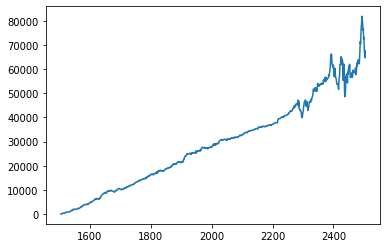

In [97]:
n_shares = 100
# If our prediction == 1, buy 100 shares; otherwise short-sell 100 shares
df_test['position'] = np.where(df_test['y_pred'] == 1, n_shares, -n_shares)
# Our profit is the number of shares we bought today, times the change in price tomorrow
df_test['profit'] = df_test['position'] * df_test['delta_tm']
df_test['profit_cumul'] = df_test['profit'].cumsum()
df_test['profit_cumul'].plot()